# 某电商平台针对优化落地页设计的A/B测试

## 1. 确定实验样本量

In [1]:
# 使用Python完成最小样本量计算
import numpy as np 
import pandas as pd 
import scipy.stats as stats 
import statsmodels.stats.api as sms 
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import seaborn as sns 

In [2]:
# 根据我们的预期比率计算效果量
effect_size = sms.proportion_effectsize(0.13, 0.15) 

In [3]:
effect_size

-0.0576728617308947

In [4]:
# 计算所需的样本量
required_n = sms.NormalIndPower().solve_power( 
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1 ,
    ) 

In [5]:
required_n

4719.4740575998185

In [6]:
# 向上取整
np.ceil(required_n)

4720.0

In [7]:
# 此次AB测试至少需要9440个用户参与测试
np.ceil(required_n)*2 

9440.0

## 2. 数据导入 

In [8]:
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


<div class="alert alert-block alert-success">
    
- 字段名称含义：
    - user_id：用户ID
    - timestamp：用户访问页面的时间
    - group：用户分组情况（新落地页为treatment组，旧版落地页为control组）
    - landing_page：每位用户看到的落地页（分为新旧两版落地页）
    - converted：是否成功转化（1代表成功转化，0代表未转化）
    
</div>

In [10]:
df["group"].value_counts()

treatment    147276
control      147202
Name: group, dtype: int64

In [11]:
df["landing_page"].value_counts()

old_page    147239
new_page    147239
Name: landing_page, dtype: int64

## 3. 数据清洗 

<div class="alert alert-block alert-success">
    
- 检查缺失值、重复值
    
</div>

In [12]:
# 检查缺失值并处理
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [13]:
# 检查重复值并处理
df.duplicated().sum() #对于整体数据集没有重复值

0

In [14]:
# 检查用户是否有重复值
df["user_id"].duplicated().sum()

3894

In [15]:
df[df["user_id"].duplicated()]["user_id"]

2656      698120
2893      773192
7500      899953
8036      790934
10218     633793
           ...  
294308    905197
294309    787083
294328    641570
294331    689637
294355    744456
Name: user_id, Length: 3894, dtype: int64

In [16]:
# 查看其中一位重复用户
df[df["user_id"]==698120]

,user_id,timestamp,group,landing_page,converted
988,698120,09:37.5,control,new_page,0
2656,698120,13:42.6,control,old_page,0


In [17]:
# 储存所有的重复用户ID，准备删除
del_id = df[df["user_id"].duplicated()]["user_id"].values

In [18]:
# 需要删除的重复样本量
df["user_id"].isin(del_id).sum()

7788

In [19]:
~df["user_id"].isin(del_id)

0         True
1         True
2         True
3         True
4         True
          ... 
294473    True
294474    True
294475    True
294476    True
294477    True
Name: user_id, Length: 294478, dtype: bool

In [20]:
# 删除后生成新的df
df_new = df[~df["user_id"].isin(del_id)]
df_new

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1
...,...,...,...,...,...
294473,751197,28:38.6,control,old_page,0
294474,945152,51:57.1,control,old_page,0
294475,734608,45:03.4,control,old_page,0
294476,697314,20:29.0,control,old_page,0


<div class="alert alert-block alert-success">
    
- 接下来，要保证control组对应old_page,treatment组对应new_page
    
</div>

In [21]:
(((df_new['group']=='treatment')&(df_new['landing_page']=='new_page'))|((df_new['group']=='control')&(df_new['landing_page']=='old_page'))).sum()

286690

In [22]:
# 确保contorl组每个用户看到的是旧页面，treatment组看到的是新页面
pd.crosstab(df_new['group'], df_new['landing_page'])

landing_page,new_page,old_page
group,,
control,0,143293
treatment,143397,0


<div class="alert alert-block alert-success">
    
- 至此，所有的数据清洗工作已完成
    
</div>

## 4. 抽样

<div class="alert alert-block alert-warning">
 
**思考：**     
1. 根据前面最小样本量的计算，我们至少需要每组4720个样本，这里我们选择每组抽样5000个（**实际工作中不需要抽样这一步**）
</div>

In [23]:
required_n = 5000
control_sample = df_new[df_new['group'] == 'control'].sample(n=required_n, random_state=0) 
treatment_sample = df_new[df_new['group'] == 'treatment'].sample(n=required_n, random_state=0) 

ab_test = pd.concat([control_sample, treatment_sample], axis=0) 
ab_test.reset_index(drop=True, inplace=True)
ab_test

,user_id,timestamp,group,landing_page,converted
0,740761,06:22.2,control,old_page,0
1,685906,37:19.4,control,old_page,0
2,803229,46:36.5,control,old_page,0
3,771051,49:52.4,control,old_page,0
4,726377,18:54.6,control,old_page,0
...,...,...,...,...,...
9995,721371,27:27.0,treatment,new_page,0
9996,795324,53:31.9,treatment,new_page,0
9997,895599,04:03.6,treatment,new_page,0
9998,760897,24:15.8,treatment,new_page,0


In [24]:
pd.crosstab(ab_test['group'], ab_test['landing_page'])

landing_page,new_page,old_page
group,,
control,0,5000
treatment,5000,0


## 5. 转化率计算

In [25]:
conversion_rates = ab_test.groupby('group')['converted'].agg([np.mean,np.std])
conversion_rates

,mean,std
group,,
control,0.1122,0.315644
treatment,0.1202,0.325228


In [26]:
# 更换列名
conversion_rates.columns = ['conversion_rate', 'std_deviation']
conversion_rates

,conversion_rate,std_deviation
group,,
control,0.1122,0.315644
treatment,0.1202,0.325228


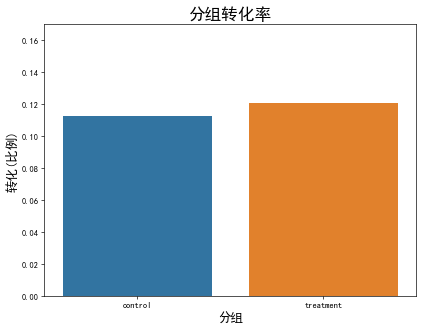

In [27]:
plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(8,6),dpi=60) 
sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False) 
plt.ylim(0, 0.17) 
plt.title( '分组转化率', fontsize=20) 
plt.xlabel('分组', fontsize=15) 
plt.ylabel('转化(比例)', fontsize=15);

<div class="alert alert-block alert-success">
    
- 从上面的统计数据来看，新旧两版落地页的表现结果非常相近，相比于旧版落地页，新版落地页的转化率略微好一点点，高了0.8%
    
</div>

<div class="alert alert-block alert-warning">
 
**思考：**     
1. 那么，这种差异在统计学上显著么？我们可以直接说，新版落地页更好么？
</div>

<div class="alert alert-block alert-success">
    
- 需要通过假设检验进行验证
    
</div>

## 6. 假设检验

<div class="alert alert-block alert-success">
    
- 在统计学中，当样本容量较大时（一般是大于30），我们可以使用Z检验或者t检验。
- 在这个案例中，由于我们的样本非常大，所以我们使用Z检验。Python中的statsmodels.stats.proportion模块可以来计算P值和置信区间：
</div>

In [28]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']

In [29]:
# 1的个数
control_results.sum()

561

In [30]:
# 1的个数
treatment_results.sum()

601

In [31]:
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

In [32]:
nobs

[5000, 5000]

In [33]:
successes

[561, 601]

In [34]:
z_stat, pval = proportions_ztest(successes, nobs=nobs)

In [35]:
z_stat

-1.2481877864638855

In [36]:
# p值
pval

0.21196229562845081

In [37]:
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes,
                                                                        nobs=nobs, 
                                                                        alpha=0.05)
print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -1.25
p-value: 0.212
ci 95% for control group: [0.103, 0.121]
ci 95% for treatment group: [0.111, 0.129]


## 6. 结果分析与建议

<div class="alert alert-block alert-success">
    
- 由于我们计算出来的P值=0.212远高于显著水平 𝛼=0.05
 ，所以我们不能拒绝原假设H0.这意味着新版落地页与旧版落地页没有明显不同（更不用说更好了）
- 此外，我们继续看置信区间，treatment组的置信区间为 [0.111, 0.129]，可以看出：
    - 它包括我们的转化率基准线13%
    - 但它不包括我们的转化率目标值15%
    - 这就说明，新版落地页的真实转化率更有可能与我们的基线相似，而没有办法达到我们期望的15%。进一步证明了，新版设计并不是一个很好的改进。
</div>